In [338]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

# ML from scratch
class hmm:
    def __init__(self,n,A,p,mu,sig):
        self.n = int(n)
        self.A = np.asarray(A)
        self.p = np.asarray(p)
        self.mu = mu
        self.sig = sig
        self.h = [None]
        self.x = [None]
        self.steps = 0
        
    def sample(self,steps):
        self.steps = steps
        self.h = np.random.choice(self.n, size=steps, p=list(self.p))
        self.x = np.random.normal(loc=self.mu[self.h[0]],scale=self.sig[self.h[0]],size=steps)
        for i in range(steps-1):
            self.h[i+1] = np.random.choice(self.n,size=1,p=list(self.A[:,self.h[i]]))
            self.x[i+1] = np.random.normal(loc=self.mu[self.h[i+1]],scale=self.sig[self.h[i+1]],size=1)
        return self.h, self.x
    
    def fit(self,x_obs,delta_tol,iter_max):
        # initialized your marginals for hidden state
        self.steps = len(x_obs)
        self.x = x_obs
        self.h_marginal = np.ones((self.n,self.steps))
        delta_curr = np.ones(1)
        iter_curr = 0
        while delta_curr>delta_tol and iter_curr<iter_max:
            mu_old = self.mu
            # E-step:
            self.h_marginal = self.E_step(self.x,self.A, self.p, self.mu, self.sig)
            # M-step
            self.A, self.p, self.mu, self.sig = self.M_step(self.x,self.h_marginal)
            # check how much the estimated mean has moved increase counter
            delta_curr = np.sum(np.abs(self.mu-mu_old)) 
            iter_curr+=1
        return self, iter_curr
    
    def infer(self,observed_x_seq):
        hidden = Viterbi()
        return hidden
        
    def forward(self,x,A,p,mu,sig):
        alpha = np.zeros((self.n,self.steps))
        for i in range(self.n):       
            alpha[i,0] = p[i]*ss.norm.pdf(x[0],mu[i],sig[i])
        for t in range(self.steps-1):
            for i in range(self.n):
                for j in range(self.n):
                    alpha[i,t+1] += alpha[j,t]*A[i,j]*ss.norm.pdf(x[t+1],mu[i],sig[i])
        return alpha
    
    def backward(self,x,A,p,mu,sig):
        beta = np.zeros((self.n,self.steps))
        beta[:,-1] = 1
        for t in range(self.steps-2,-1,-1):
            for i in range(self.n):
                for j in range(self.n):
                    beta[i,t] += beta[j,t+1]*A[j,i]*ss.norm.pdf(x[t+1],mu[j],sig[j])  
        return beta
    
    def E_step(self,x,A_old,p_old,mu_old,sig_old):
        alpha = self.forward(x,A_old,p_old,mu_old,sig_old) # this is an NxT matrix
        beta = self.backward(x,A_old,p_old,mu_old,sig_old) # this is an NxT matrix
        h_marginal = np.multiply(alpha,beta)
        h_marginal = np.divide(h_marginal,np.tile(np.sum(h_marginal,axis=0),(self.n,1)))
        return h_marginal
    
    def M_step(self,x,h_marginal):
        A = np.zeros((self.n,self.n))
        for i in range(self.n):
            for j in range(self.n):
                for t in range(self.steps-1):
                    A[i,j] += h_marginal[j,t]*h_marginal[i,t+1]
        # normalizethe columns
        for i in range(self.n):
            A[:,i] = A[:,i]/np.sum(A[:,i])
        # pick initial  
        p = h_marginal[:,0]
        mu = np.divide(np.matmul(h_marginal,x),np.sum(h_marginal,axis=1))
        for i in range(self.n):
            sig[i] = np.sqrt(np.matmul(h_marginal[i,:],(x-mu[i])**2)/np.sum(h_marginal[i,:]))
        return A,p,mu,sig

# some generic helper funcitons
def normalpdf(x,mu,sig):
    return 1/np.sqrt(2*np.pi*sig**2)*np.exp(-(x-mu)**2/2/sig**2)

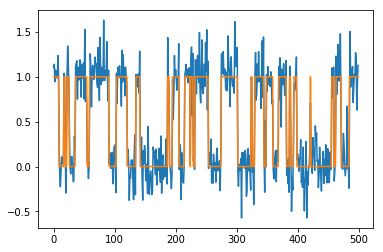

In [339]:
A = [[0.9,0.1],[0.1,0.9]]
p = [0.5,0.5]
mu = [0,1]
sig = [0.2,0.2]
T = 500;
myhmm = hmm(2,A,p,mu,sig)
h,x_obs = myhmm.sample(T)
plt.plot(x_obs)
plt.plot(h)
plt.show()

C:\Users\chong\AppData\Local\conda\conda\envs\torch\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
C:\Users\chong\AppData\Local\conda\conda\envs\torch\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


[[ nan  nan]
 [ nan  nan]]
[ 0.  0.]
[[ nan  nan]
 [ nan  nan]]


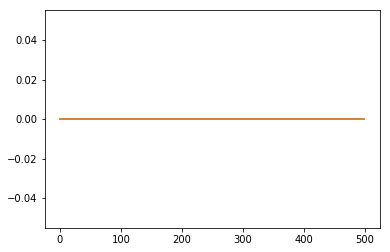

In [340]:
# now we try to learn this sequence of randomly generated observation
# intitial guesses
A0 = [[0.8,0.2],[0.2,0.8]]
p0 = [0.5,0.5]
mu0 = [0.1,0.9]
sig0 = [0.1,0.1]
tol_mu = 1e-4
iter_max = 1000
testhmm = hmm(2,A0,p0,mu0,sig0)
testhmm.sample(T)
h_marginals0= testhmm.E_step(x_obs,np.asarray(A0),np.asarray(p0),np.asarray(mu0),np.asarray(sig0))
A1,p1,mu1,sig1 = testhmm.M_step(x_obs,h_marginals0)
print(A1)
print(p1)
h_marginals1= testhmm.E_step(x_obs,np.asarray(A1),np.asarray(p1),np.asarray(mu1),np.asarray(sig1))
A2,p2,mu2,sig2 = testhmm.M_step(x_obs,h_marginals1)
print(A2)
plt.plot(h_marginals0.T)
plt.show()
#hmmfit,iters = testhmm.fit(x_obs,tol_mu,iter_max)
#print(iters)
#print(hmmfit.A)
#print(hmmfit.p)
#print(hmmfit.mu)
#print(hmmfit.sig)